# DATASET USED: https://www.kaggle.com/datasets/tongpython/cat-and-dog

**License
CC0: Public Domain**

**Code author: Andrei Ciprian Alexandru**

**URN: 6592956**

**Notebook created: 29/03/2023**

**Last update: 16/05/2023**

# ***Import the necessary libraries***

In [1]:
import os
import random
import numpy as np
from PIL import Image
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import itertools
import graphviz
import csv
from graphviz import Digraph
from torchvision import models

# ***Define a class to load the dataset correctly***

In [2]:
# Define a custom dataset to handle the specific folder structure
class CatDogDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = []
        for cls, class_dir in enumerate(['cats', 'dogs']):
            class_path = os.path.join(root, class_dir)
            for img_file in os.listdir(class_path):
                if img_file.endswith('.jpg'):
                    self.samples.append((os.path.join(class_path, img_file), cls))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        return img, label

# ***Load the images and create the data loaders***

In [3]:
# Load the dataset
image_size = 224
batch_size = 64
transform = transforms.Compose([transforms.Resize((image_size, image_size)), transforms.ToTensor()])
train_dataset = CatDogDataset('/kaggle/input/cat-and-dog/training_set/training_set', transform)
test_dataset = CatDogDataset('/kaggle/input/cat-and-dog/test_set/test_set', transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ***Plot dataset analytics***

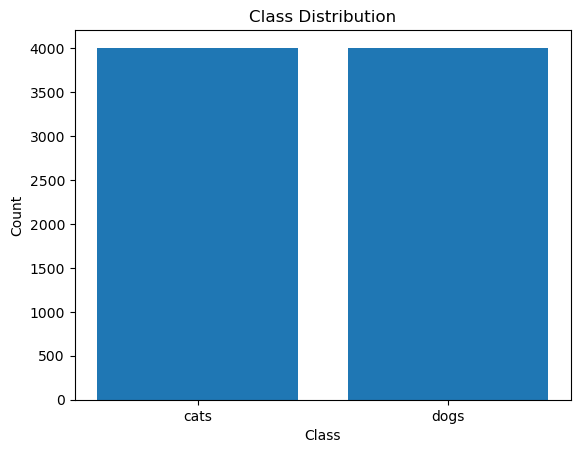

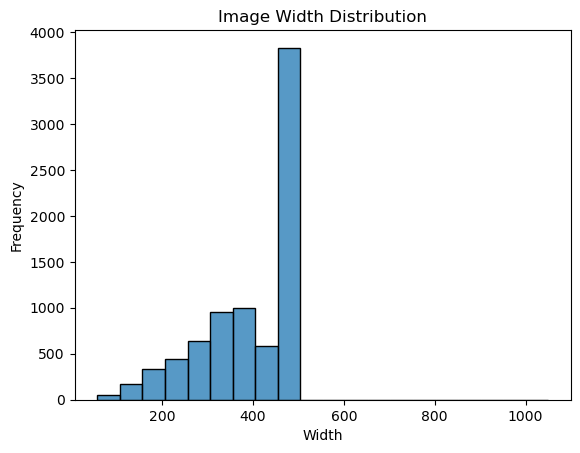

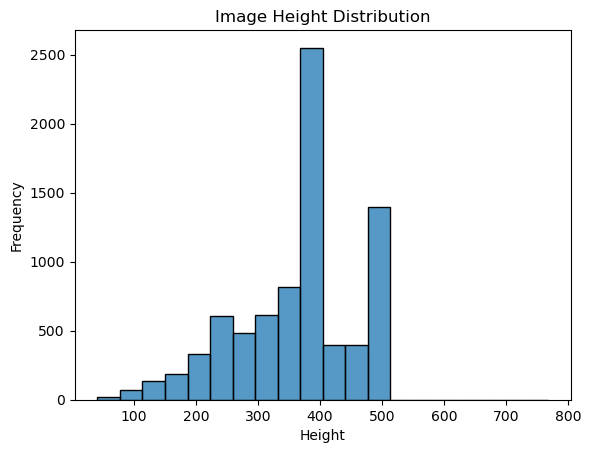

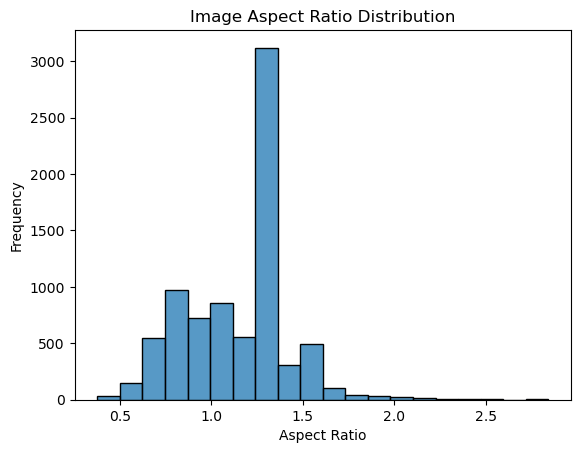

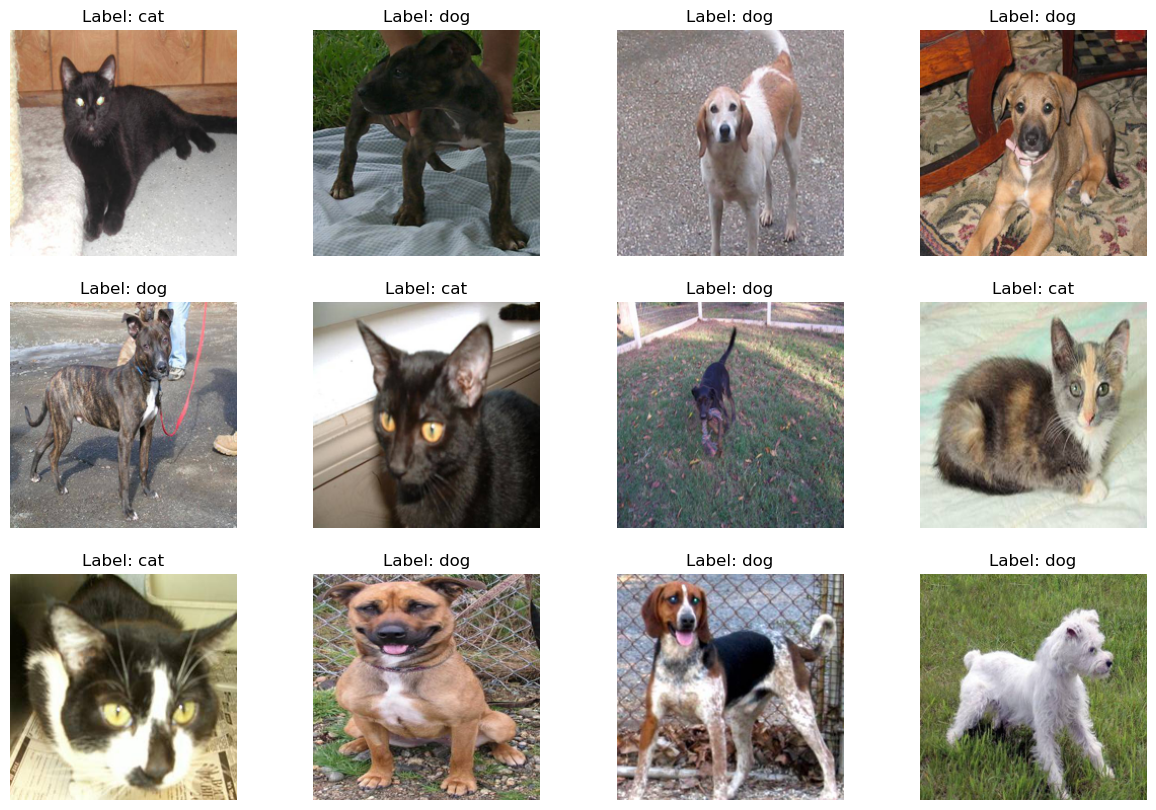

In [4]:
# Count the number of images per class
class_counts = {'cats': 0, 'dogs': 0}
for _, label in train_dataset.samples:
    if label == 0:
        class_counts['cats'] += 1
    else:
        class_counts['dogs'] += 1

# Plot class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Calculate image sizes and aspect ratios
img_widths, img_heights, img_ratios = [], [], []
for img_path, _ in train_dataset.samples:
    img = Image.open(img_path)
    width, height = img.size
    img_widths.append(width)
    img_heights.append(height)
    img_ratios.append(width / height)

# Plot image size distribution
plt.figure()
sns.histplot(x=img_widths, bins=20)
plt.title('Image Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.show()

plt.figure()
sns.histplot(x=img_heights, bins=20)
plt.title('Image Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.show()

# Plot image aspect ratio distribution
plt.figure()
sns.histplot(x=img_ratios, bins=20)
plt.title('Image Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.show()

# Display a grid of random sample images with their labels
num_samples = 12
random_indices = np.random.choice(len(train_dataset.samples), num_samples, replace=False)
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    img_path, label = train_dataset.samples[random_indices[i]]
    img = Image.open(img_path)
    img = img.resize((image_size, image_size))
    ax.imshow(img)
    ax.set_title(f"Label: {'cat' if label == 0 else 'dog'}")
    ax.axis('off')
plt.show()


# ***Import the pre-trained neural network and modify the last layer for binary output***

In [5]:
# Load pre-trained ResNet model
resnet_model = models.resnet18(pretrained=True)

# Modify the last layer to match the number of output classes (binary classification)
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 2)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

# ***Train the neural network***

In [6]:
# Train the neural network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use the modified resnet_model
net = resnet_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

losses = []  # Store losses for each epoch
num_epochs = 4
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss / (i + 1)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/4], Loss: 0.1465
Epoch [2/4], Loss: 0.0470
Epoch [3/4], Loss: 0.0253
Epoch [4/4], Loss: 0.0189


# ***Plot the training loss***

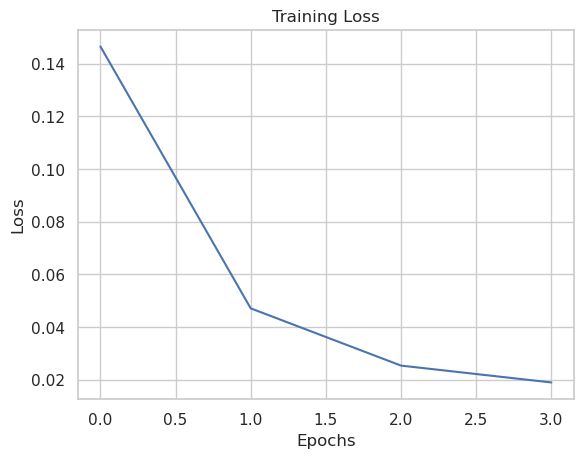

In [7]:
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# ***Calculate the neural netwrok's accuracy on unseen data***

In [8]:
def evaluate(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

train_accuracy_nn = evaluate(net, train_loader)
test_accuracy_nn = evaluate(net, test_loader)
print(f"Neural Network - Train accuracy: {train_accuracy_nn*100:.2f}%, Test accuracy: {test_accuracy_nn*100:.2f}%")

Neural Network - Train accuracy: 99.93%, Test accuracy: 99.11%


# ***Plot the neural network's confusion matrix***

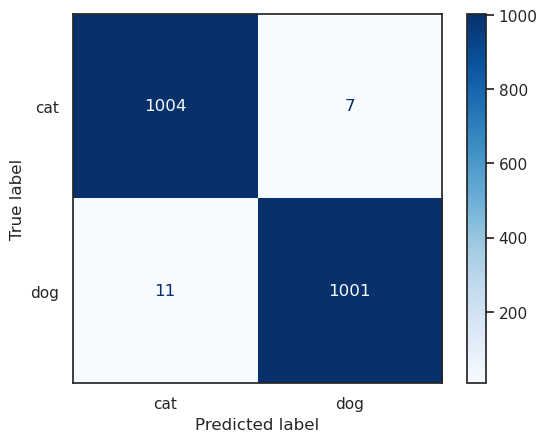

In [9]:
def get_all_preds(model, dataloader):
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds = torch.cat((all_preds, predicted), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)
    return all_preds, all_labels

test_preds, test_labels = get_all_preds(net, test_loader)
cm = confusion_matrix(test_labels.cpu(), test_preds.cpu())

# Define custom labels
class_labels = ['cat', 'dog']

sns.set(style="white")

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cmd.plot(cmap='Blues')
plt.show()

# ***Extract the features from the images using the trained neural network***

In [10]:
# Load the pre-trained neural network
net.eval()

# Define a function to extract features using a forward hook
def hook(module, input, output):
    global features
    features = output.view(output.size(0), -1).cpu().numpy()

# Attach the forward hook to the avgpool layer
handle = net.avgpool.register_forward_hook(hook)

# Extract features from the dataset using the neural network
def extract_features(loader, net):
    global features
    features_list, labels = [], []
    with torch.no_grad():
        for images, targets in loader:
            images = images.cuda()
            targets = targets.cuda()

            # Get the output of the avgpool layer
            net(images)
            features_list.append(features)
            labels.append(targets.cpu().numpy())

    return np.vstack(features_list), np.hstack(labels)

train_features, train_labels = extract_features(train_loader, net)
test_features, test_labels = extract_features(test_loader, net)

# Remove the forward hook
handle.remove()


# ***Create, train and test the decision tree***

In [11]:
# Train a decision tree using the extracted features without GA optimization
UDt = DecisionTreeClassifier()
UDt.fit(train_features, train_labels)

# Evaluate the unoptimized decision tree
train_accuracy_unoptimized = UDt.score(train_features, train_labels)
test_accuracy_unoptimized = UDt.score(test_features, test_labels)

# Print relevant information for comparison
print(f"Unoptimized tree max depth: {UDt.tree_.max_depth}")
print(f"Unoptimized tree number of branches: {UDt.tree_.n_leaves - 1}")
print(f"Unoptimized tree train accuracy: {train_accuracy_unoptimized * 100:.2f}%, "
      f"test accuracy: {test_accuracy_unoptimized * 100:.2f}%")

Unoptimized tree max depth: 20
Unoptimized tree number of branches: 77
Unoptimized tree train accuracy: 100.00%, test accuracy: 96.59%


# ***Plot the confusion matrix for the unoptimized decision tree***

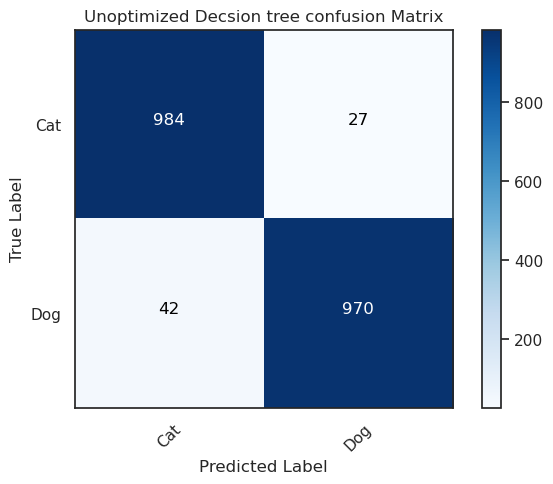

In [12]:
# Calculate the confusion matrix
test_predictions_unoptimized = UDt.predict(test_features)
cm = confusion_matrix(test_labels, test_predictions_unoptimized)

# Plot the confusion matrix
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Unoptimized Decsion tree confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Cat', 'Dog'], rotation=45)
plt.yticks(tick_marks, ['Cat', 'Dog'])

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.tight_layout()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ***Change variables for genetic algorithm here:***

In [13]:
threshold = 0.9  # Set a threshold for minimum improvement
patience = 10  # Set a patience level to allow some generations without improvement
population = 60 # Set the number of individuals per generation
generations = 100 # Set the number of maximum generations

# ***Define the genetic algorithm***

In [14]:
# Define the genetic extraction of rules algorithm
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=train_features.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#max depth and N of branches
def fitness(individual, features, labels):
    mask = np.array(individual, dtype=bool)
    masked_features = features[:, mask]
    
    if masked_features.shape[1] == 0:
        return float('inf'),

    clf = DecisionTreeClassifier()
    clf.fit(masked_features, labels)
    
    score_depth = clf.tree_.max_depth
    n_leaf_nodes = clf.tree_.n_leaves  # This attribute gives the number of leaf nodes in the tree
    score_width = n_leaf_nodes - 1  # The total number of branches is the number of leaf nodes minus 1

    score = score_depth + score_width  # Combine depth and width scores
    
    return score,

toolbox.register("evaluate", fitness, features=train_features, labels=train_labels)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=5)

population = toolbox.population(n=population)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# ***Run the genetic algorithm and extract the best feature mask***
***Please note that the code contains early stopping so the genetic algorithm might not run for the full number of generations.***

***To deactivate the early stopping set the "patience" variable to the total number of generations, in the cell above.***

In [15]:
#Define threshold and patience
no_improv_counter = 0  # Initialize a counter for iterations without improvement
prev_best_fitness = None  # Initialize a variable to hold the best fitness from the previous iteration
logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])
cxpb = 0.6
mutpb = 0.5

# Run the genetic algorithm with early stopping
for gen in range(generations):  # Run for a maximum of n generations
    population = algorithms.varAnd(population, toolbox, cxpb=cxpb, mutpb=mutpb)  # Perform mating and mutation
    invalid_ind = [ind for ind in population if not ind.fitness.valid]  # Extract individuals with invalid fitness
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)  # Evaluate the individuals with an invalid fitness
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit  # Assign new fitness values to individuals

    # Update hall of fame and statistics
    hof.update(population)
    record = stats.compile(population)
    logbook.record(gen=gen, **record)

    # Print current generation and best fitness
    print("Generation: ", gen, ", Best Fitness: ", hof[0].fitness.values[0])

    # Check for improvement
    if prev_best_fitness is None or hof[0].fitness.values[0] < prev_best_fitness - threshold:
        no_improv_counter = 0  # Reset the counter
        prev_best_fitness = hof[0].fitness.values[0]  # Update the previous best fitness
        cxpb = cxpb - 0.2
        mutpb = mutpb - 0.2
    else:
        no_improv_counter += 1  # Increment the counter
        
    # Modify parameters
    if no_improv_counter == patience/2 and mutpb <= 0.7:
        print("Changing parameters to be more aggresive")
        cxpb = cxpb + 0.4
        mutpb = mutpb + 0.4
    
    # Early stopping
    if no_improv_counter >= patience:
        print("Stopping early due to lack of improvement.")
        break

# Extract the best individual (feature mask)
best_individual = hof[0]

Generation:  0 , Best Fitness:  94.0
Generation:  1 , Best Fitness:  93.0
Generation:  2 , Best Fitness:  93.0
Generation:  3 , Best Fitness:  93.0
Generation:  4 , Best Fitness:  93.0
Generation:  5 , Best Fitness:  93.0
Generation:  6 , Best Fitness:  93.0
Changing parameters to be more aggresive
Generation:  7 , Best Fitness:  93.0
Generation:  8 , Best Fitness:  93.0
Generation:  9 , Best Fitness:  93.0
Generation:  10 , Best Fitness:  91.0
Generation:  11 , Best Fitness:  91.0
Generation:  12 , Best Fitness:  91.0
Generation:  13 , Best Fitness:  91.0
Generation:  14 , Best Fitness:  91.0
Generation:  15 , Best Fitness:  91.0
Changing parameters to be more aggresive
Generation:  16 , Best Fitness:  91.0
Generation:  17 , Best Fitness:  89.0
Generation:  18 , Best Fitness:  89.0
Generation:  19 , Best Fitness:  89.0
Generation:  20 , Best Fitness:  89.0
Generation:  21 , Best Fitness:  85.0
Generation:  22 , Best Fitness:  85.0
Generation:  23 , Best Fitness:  85.0
Generation:  24 

# ***Plot the genetic algorithm fitness***

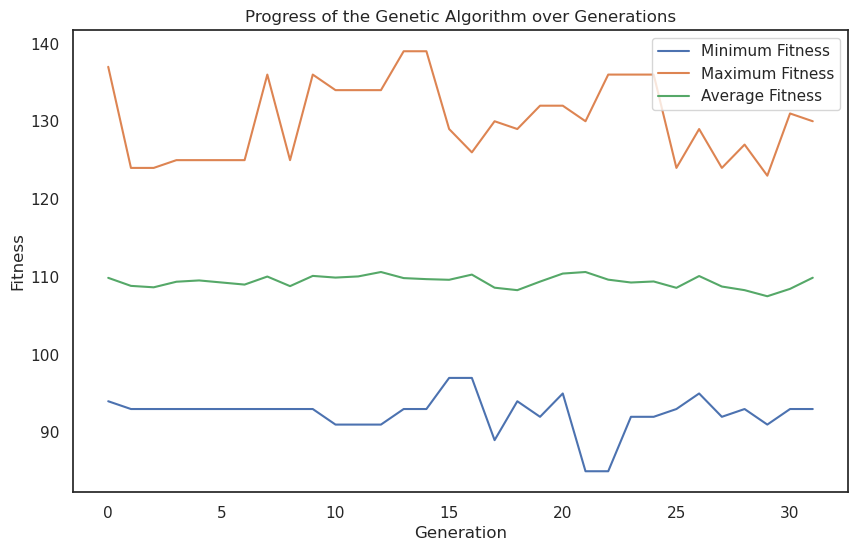

In [16]:
import matplotlib.pyplot as plt

# Extract data from the logbook
min_fitness_values = logbook.select('min')
max_fitness_values = logbook.select('max')
avg_fitness_values = logbook.select('avg')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(min_fitness_values, label='Minimum Fitness')
plt.plot(max_fitness_values, label='Maximum Fitness')
plt.plot(avg_fitness_values, label='Average Fitness')

# Customize the plot
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Progress of the Genetic Algorithm over Generations')
plt.legend(loc='upper right')

# Show the plot
plt.show()


# ***Create, train and test the optimized decision tree***

In [17]:
# Train and evaluate the decision tree with the best feature mask
mask = np.array(best_individual, dtype=bool)
ODt = DecisionTreeClassifier()
ODt.fit(train_features[:, mask], train_labels)
train_accuracy = (ODt.predict(train_features[:, mask]) == train_labels).mean()
test_accuracy = (ODt.predict(test_features[:, mask]) == test_labels).mean()

# Calculate the number of branches for the best individual
n_leaf_nodes = ODt.tree_.n_leaves
n_branches = n_leaf_nodes - 1

print(f"Best individual: {best_individual}")
print(f"Number of selected features: {sum(best_individual)}")
print(f"Max tree depth: {ODt.tree_.max_depth}")
print(f"Number of branches: {n_branches}")
print(f"Train accuracy: {train_accuracy * 100:.2f}%, Test accuracy: {test_accuracy * 100:.2f}%")

Best individual: [1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0

# ***Plot the confusion matrix for the optimized decision tree***

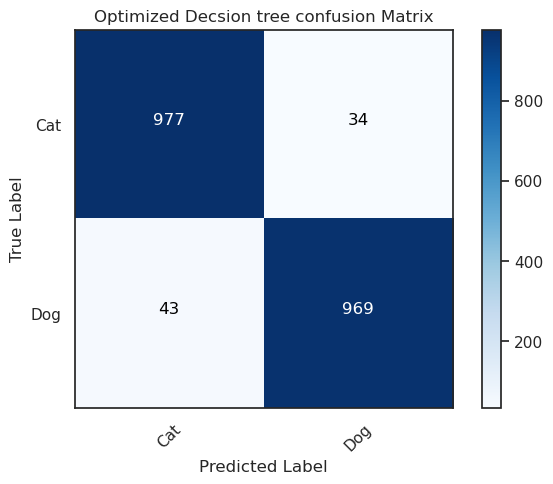

In [18]:
# Calculate the confusion matrix
test_predictions_optimized = ODt.predict(test_features[:, mask])
cm = confusion_matrix(test_labels, test_predictions_optimized)

# Plot the confusion matrix
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Optimized Decsion tree confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Cat', 'Dog'], rotation=45)
plt.yticks(tick_marks, ['Cat', 'Dog'])

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.tight_layout()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ***Plot a bar chart to compare the accuracy of the unoptimized decision tree and the optimized decision tree***

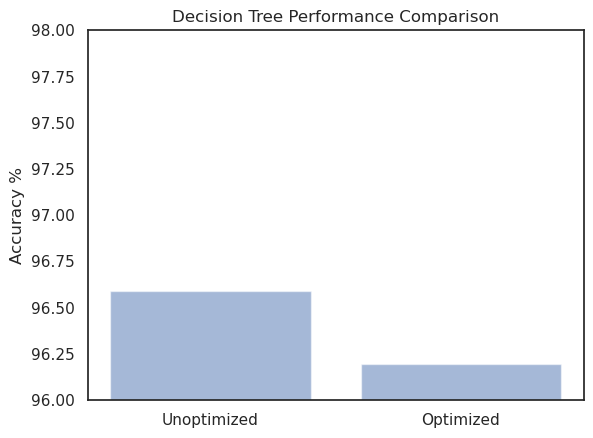

In [19]:
# Compare the performance of the unoptimized and optimized decision trees
objects = ('Unoptimized', 'Optimized')
y_pos = np.arange(len(objects))
performance = [test_accuracy_unoptimized * 100,  test_accuracy * 100]

plt.figure()
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy %')
plt.title('Decision Tree Performance Comparison')
plt.ylim(96, 98)

plt.show()

# ***Save the variables of the run to a csv file***

In [20]:
# Gather the data you want to save
data = [
    ("Image Size", image_size),
    ("Batch Size", batch_size),
    ("Neural network Num epochs", num_epochs),
    ("Neural network Train Accuracy", f"{train_accuracy_nn * 100:.2f}%"),
    ("Neural network Test Accuracy", f"{test_accuracy_nn * 100:.2f}%"),
    ("Number of Generations", generations),
    ("Population", population),
    ("Number of Selected Features", sum(best_individual)),
    ("Max Tree Depth", ODt.tree_.max_depth),
    ("Number of Branches", n_branches),
    ("GA OPT DT Train Accuracy", f"{train_accuracy * 100:.2f}%"),
    ("GA OPT DT Test Accuracy", f"{test_accuracy * 100:.2f}%"),
    ("Unoptimized Tree Max Depth", UDt.tree_.max_depth),
    ("Unoptimized Tree Number of Branches", UDt.tree_.n_leaves - 1),
    ("Unoptimized Tree Train Accuracy", f"{train_accuracy_unoptimized * 100:.2f}%"),
    ("Unoptimized Tree Test Accuracy", f"{test_accuracy_unoptimized * 100:.2f}%"),
]

# Save the data to a CSV file
with open("results.csv", "w", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["Parameter", "Value"])
    for row in data:
        csv_writer.writerow(row)


# ***Define the methods to save the plots of the decision trees and the decision trees with the classifiaction path for an image highlighted***

In [21]:
def traverse_and_color(node, decision_path, graph):
    if not node:
        return

    if node in decision_path:
        graph.node(str(node), label=node.label, color='red', fontcolor='red')
        traverse_and_color(node.left, decision_path, graph)
        traverse_and_color(node.right, decision_path, graph)
    else:
        graph.node(str(node), label=node.label)
        traverse_and_color(node.left, decision_path, graph)
        traverse_and_color(node.right, decision_path, graph)
        
def get_decision_path(clf, features):
    tree = clf.tree_
    node = 0
    decision_path = []

    while tree.children_left[node] != tree.children_right[node]:
        decision_path.append(node)
        if features[tree.feature[node]] <= tree.threshold[node]:
            node = tree.children_left[node]
        else:
            node = tree.children_right[node]
    
    decision_path.append(node)  # Add the leaf node to the path
    return decision_path
        
def visualize_tree(clf, feature_names, class_names, decision_path=None, filename=None):
    dot_data = export_graphviz(
        clf, out_file=None,
        feature_names=feature_names,
        class_names=class_names,
        filled=True, rounded=True,
        special_characters=True
    )
    
    graph = Digraph(filename = filename)
    tree = clf.tree_
    tree_nodes = tree.node_count
    decision_path = set() if decision_path is None else set(decision_path)

    # Build the decision tree graph
    for node in range(tree_nodes):
        if tree.children_left[node] != tree.children_right[node]:
            label = f'{feature_names[tree.feature[node]]} <= {tree.threshold[node]:.2f}'
            graph.node(str(node), label=label, shape='box', color='red' if node in decision_path else 'black', penwidth='3' if node in decision_path else '1')
            if tree.children_left[node] != -1:
                graph.edge(str(node), str(tree.children_left[node]), label='True', color='red' if tree.children_left[node] in decision_path else 'black', penwidth='3' if tree.children_left[node] in decision_path else '1')
            if tree.children_right[node] != -1:
                graph.edge(str(node), str(tree.children_right[node]), label='False', color='red' if tree.children_right[node] in decision_path else 'black', penwidth='3' if tree.children_right[node] in decision_path else '1')
        else:
            label = f'{class_names[np.argmax(tree.value[node])]}'
            graph.node(str(node), label=label, shape='ellipse', color='red' if node in decision_path else 'black', penwidth='3' if node in decision_path else '1')

    return graph

# ***Load and preprocess the image***

In [22]:
def load_and_preprocess_image(image_path, image_size=224):
    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return preprocess(image).unsqueeze(0)

image_path = "/kaggle/input/dogimagepublicdomain/pexels-mathieu-gervais-14666143.jpg"
dog_image = load_and_preprocess_image(image_path)

def extract_features_single_image(image, net):
    global features
    with torch.no_grad():
        image = image.cuda()
        # Get the output of the avgpool layer
        net(image)
        features_single = features

    return features_single

dog_features = extract_features_single_image(dog_image, net)
dog_prediction = UDt.predict(dog_features)

tree = UDt.tree_
node_id = tree.apply(dog_features.astype(np.float32))[0]  # Get the leaf node ID for the dog image
feature_names = [f'Feature {i}' for i in range(train_features.shape[1])]

In [23]:
decision_path = get_decision_path(UDt, dog_features[0])
graph = visualize_tree(UDt, feature_names, ['Cat', 'Dog'], decision_path=decision_path, filename='Unptimised_path')
graph.view()

graph = visualize_tree(UDt, feature_names, ['Cat', 'Dog'], filename='Unoptimised_tree')
graph.view()

Error: no "view" mailcap rules found for type "application/pdf"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'Unptimised_path.pdf'


'Unoptimised_tree.pdf'

In [24]:
# Get the optimized feature names
optimized_feature_names = np.array(feature_names)[mask]

# Extract the features for the dog image using the mask
optimized_dog_features = dog_features[:, mask]

# Get the decision path for the optimized tree
optimized_decision_path = get_decision_path(ODt, optimized_dog_features[0])

# Visualize the optimized tree with the highlighted decision path
optimized_graph = visualize_tree(ODt, optimized_feature_names, ['Cat', 'Dog'], decision_path=optimized_decision_path, filename='Optimised_path')
optimized_graph.view()

# Visualize the optimized tree with the highlighted decision path
optimized_graph = visualize_tree(ODt, optimized_feature_names, ['Cat', 'Dog'], filename='Optimised_tree')
optimized_graph.view()

Error: no "view" mailcap rules found for type "application/pdf"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'Unoptimised_tree.pdf'
Error: no "view" mailcap rules found for type "application/pdf"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'Optimised_path.pdf'


'Optimised_tree.pdf'